In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pickle
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import glob
import random
import tensorflow as tf
import seaborn as sns
import re
import tarfile
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.optimizers import adam_v2
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
# import keras_tuner as kt
from keras import optimizer_v2
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

Mounted at /content/gdrive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
train_annotation = pickle.load(open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/train_annotation.pkl', 'rb'))
test_annotation = pickle.load(open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_annotation.pkl', 'rb'))
test_dev_annotation = pickle.load(open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_dev_annotation.pkl', 'rb'))

In [ ]:
file = tarfile.open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_train.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
file = tarfile.open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_test.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
file = tarfile.open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_dev.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
import os
import shutil

src = '/content/vehicle_images/images_train/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
src = '/content/vehicle_images/images_test/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
src = '/content/vehicle_images/images_dev/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
train_annotation.keys(), test_annotation.keys(), test_dev_annotation.keys()

In [ ]:
annotations = {}
for ind in train_annotation['type_label']:
    img_name = train_annotation['train_im_names'][ind]
    annotations[img_name] = train_annotation['type_label'][ind]

In [ ]:
annotations.update(test_annotation['type_label'])
annotations.update(test_dev_annotation['type_label'])

In [ ]:
print(annotations['00000207_0002_00000001.jpg'])

In [ ]:
Counter(annotations.values())

In [ ]:
strategy = {0:1500, 1:950, 2:1500, 3:700, 4:1300, 5:1150, 6:0}
undersample = RandomUnderSampler(sampling_strategy = strategy)
X, y = np.array(list(annotations.keys())), np.array(list(annotations.values()))
X = X.reshape(-1,1)
y = y.reshape(-1,1)
annot_name, annot_label = undersample.fit_resample(X, y)
Counter(annot_label)

In [ ]:
data, label = [], []
path = '/content/vehicle_images/'
for i in range(7100):
    img_name = path+annot_name[i][0]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    data.append(img)
    label.append(annot_label[i])

# label = pd.get_dummies(label).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42, stratify=label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
for i in range(len(X_train)):
  X_train[i]=cv2.normalize(X_train[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_val)):
  X_val[i]=cv2.normalize(X_val[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_test)):
  X_test[i]=cv2.normalize(X_test[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) 

In [ ]:
X_train = np.array(X_train).astype('float32')
X_val = np.array(X_val).astype('float32')
X_test = np.array(X_test).astype('float32')
y_train = np.array(y_train).reshape((-1,1))
y_val = np.array(y_val).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))

In [ ]:
X_train.shape, X_val.shape, X_test.shape

In [ ]:
y_train.shape, y_val.shape, y_test.shape

In [ ]:
feature_extractor_model = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
num_of_cars = 6

model = Sequential([
  pretrained_model_without_top_layer,
  Dense(num_of_cars)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,573,446
Trainable params: 12,294
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=5)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
y_pred[99], y_test[99]

(2, array([4]))

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.74      0.67       300
           1       0.65      0.33      0.43       190
           2       0.59      0.55      0.57       300
           3       0.90      0.84      0.87       140
           4       0.59      0.71      0.64       260
           5       0.82      0.83      0.82       230

    accuracy                           0.66      1420
   macro avg       0.69      0.67      0.67      1420
weighted avg       0.67      0.66      0.66      1420



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'])

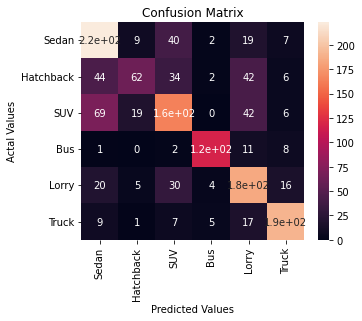

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()